In [ ]:
"""
Wine Reviews dataset from Kaggle.com is a dataset build on reviews 
people gave for wines from different countries.

Before looking into more extensive classification or other NLP tasks 
it is interesting to look into the dataset to get first insights 
and have some data to work with later.
To make the dataset fit the task, only two country of wine origin are considered.

NLP tasks for this dataset include:
- most frequent relevant words
- class proportionality
- mid description length
- term frequency analysis
- binary classification
- n-gram analysis

"""

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [4]:
# global variables
# printing_precision allows to change the number of tokens to be printed for analysis
n_classes = 2 
printing_precision = 20 

# upper-case parameters and kwargs for sklearn classificator
NGRAM_RANGE = (1, 3)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOCUMENT_FREQUENCY = 5

kwargs = {
        'norm': None,
        'stop_words': 'english',
        'ngram_range': NGRAM_RANGE,
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,
        'min_df': MIN_DOCUMENT_FREQUENCY
}

In [14]:
# dataset can be downloaded from 
# https://www.kaggle.com/zynicide/wine-reviews

path = '/home/ksu/projects/data'
data_path = os.path.join(path, 'Reviews.csv')

assert os.path.isfile(data_path) is True

In [3]:
# load reviews.csv file and select two columns: 
# country holds a string with a country name
# description holds a string with a raw review
# reviews might hold a lot of numbers which can be dropped
 
reviews = pd.read_csv(data_path)
reviews = reviews[['country', 'description']]
reviews.description = reviews.description.str.replace('[^a-zA-Z\']+', ' ')

In [5]:


def get_nclass_df(data_df, n_classes=3):
    """
    The dataset has a variety of wine origins, 
    so for simplification a new dataframe is created 
    with n classes in original order
    Countires are sorted by popularity
    Args:
        data_df (pandas DataFrame): reviews dataframe
        n_classes (int): number of countries to leave
    Returns:
        n_country_reviews (pandas DataFrame): a new dataframe with chosen n countries
        top_countries (list of str): names of chosen countires
    """
    n_country_reviews = pd.DataFrame(columns=['country', 'description'])
    top_countries = data_df.country.value_counts()[:n_classes].keys()
    for country in top_countries:
        country_reviews = pd.DataFrame(data_df[data_df.country == country])
        n_country_reviews = n_country_reviews.append(country_reviews)
    return n_country_reviews, top_countries

def add_splits(data_df, classes, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    
    """
    split_reviews = pd.DataFrame(columns=['country', 'description', 'split'])
    for country in classes:
        country_reviews = pd.DataFrame(data_df[data_df.country == country])
        n_total = len(country_reviews)
        n_train = int(n_total * train_prop)
        n_val = int(n_total * val_prop)
        n_test = int(n_total * test_prop)

        country_reviews['split'] = None
        country_reviews.split.iloc[:n_train] = 'train'
        country_reviews.split.iloc[n_train:n_train+n_val] = 'val'
        country_reviews.split.iloc[n_train+n_val:] = 'test'

        split_reviews = split_reviews.append(country_reviews)
    return split_reviews


reviews, classes = get_nclass_df(reviews, n_classes)
reviews = add_splits(reviews, classes)
train_corpus = reviews[reviews.split == 'train'].description.values

In [6]:
vectorizer = CountVectorizer(stop_words='english')
vectorized_texts = vectorizer.fit_transform(train_corpus)
print("vocabulary size: {}".format(len(vectorizer.vocabulary_)))

vocabulary size: 20315


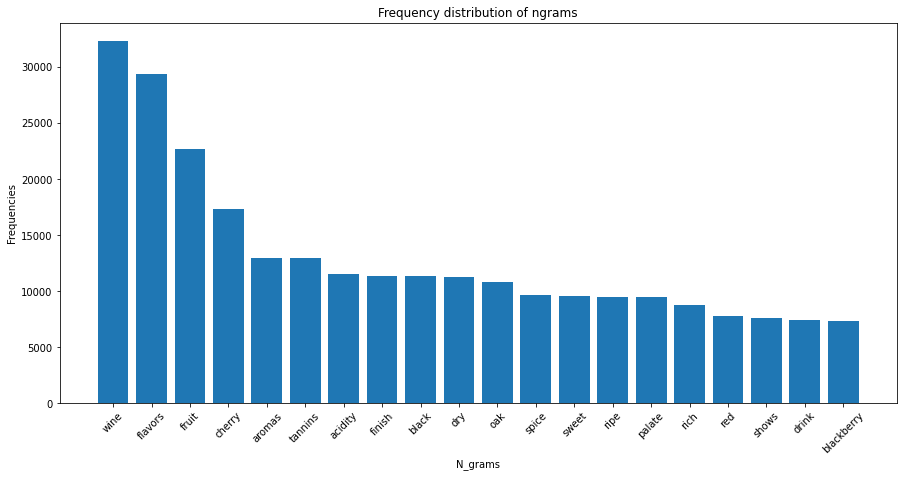

In [7]:
all_ngrams = list(vectorizer.get_feature_names())
num_ngrams = len(all_ngrams)

all_counts = vectorized_texts.sum(axis=0).tolist()[0]
result = [(c, n) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)]
all_counts, all_ngrams = zip(*result)

ngrams = list(all_ngrams)[:printing_precision]
counts = list(all_counts)[:printing_precision]

idx = np.arange(printing_precision)
plt.figure(figsize=(15, 7))
plt.bar(idx, counts, width=.8)
plt.xlabel('N_grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

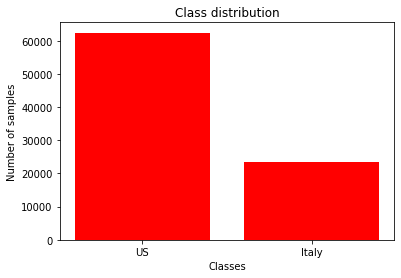

In [8]:
counts = reviews.country.value_counts().values
classes = reviews.country.unique()

plt.figure()
plt.bar(classes, counts, width=.8, color='r')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class distribution')
plt.show()

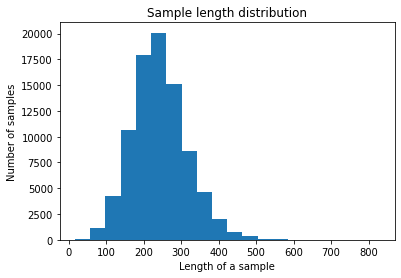

In [9]:
review_lens = reviews.description.str.len().values

plt.hist(review_lens, printing_precision)
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [10]:
vectorizer = TfidfVectorizer(**kwargs)
x_train = vectorizer.fit_transform(train_corpus).astype('float32')
y_train = (reviews[reviews.split == 'train'].country == 'US').astype(int).values

max_value = x_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names())
print("Feature names with lowest tfidf:\n{}".format(
feature_names[sorted_by_tfidf[:printing_precision]]))

print("Feature names with highest tfidf:\n{}".format(
feature_names[sorted_by_tfidf[-printing_precision:]]))

sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
feature_names[sorted_by_idf[:printing_precision]]))

/home/ksu/projects/Word2Vec/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Feature names with lowest tfidf:
['pair' 'crisp acidity' 'finishes' 'spice flavors' 'structured'
 'raspberry cherry' 'cherry flavors' 'buttered toast' 'blackberry cherry'
 'sandalwood' 'white pepper' 'medium bodied' 'smoky oak' 'forest'
 'oak flavors' 'bone dry' 'wrapped' 'honeysuckle' 'cherry blackberry'
 'wild berry']
Feature names with highest tfidf:
['chinese' '18 months' 'horse' 'friulano' 'percent' '04' 'klipsun' 'nero'
 'spice mineral' '33' 'monte' 'banana' '25' 'iron horse' 'walla' 'figgins'
 'nickel' 'cailloux' 'partly' 'est']
Features with lowest idf:
['flavors' 'wine' 'fruit' 'cherry' 'aromas' 'tannins' 'acidity' 'finish'
 'dry' 'oak' 'black' 'spice' 'palate' 'ripe' 'sweet' 'rich' 'shows'
 'drink' 'blackberry' 'red']


Best cross-validation score: 0.99
Best parameters:  {'C': 0.1}


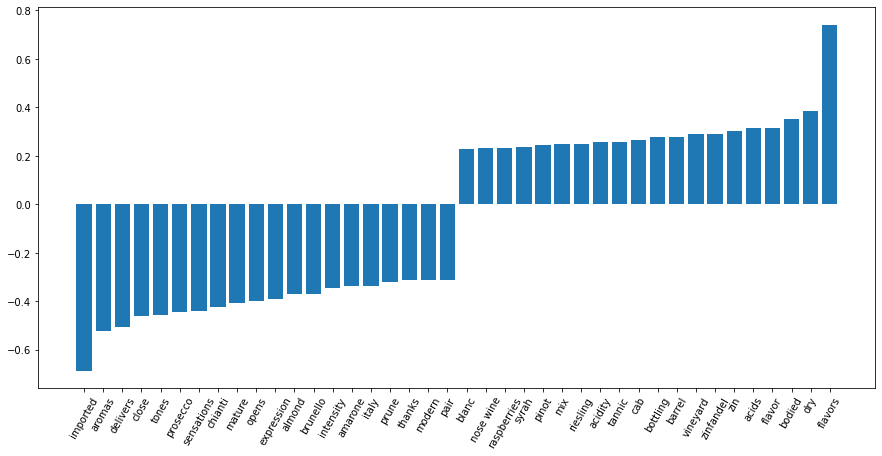

In [11]:

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(x_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

clf = grid.best_estimator_.fit(x_train, y_train)
coef = clf.coef_.ravel()
list = [(n, c) for n, c in zip(feature_names, coef)]
list = sorted(list, key=lambda x: x[1])
list = list[:20] + list[-20:]

words, coef = zip(*list)
idx = np.arange(len(words))

plt.figure(figsize=(15,7))
plt.bar(idx, coef, width=0.8)
plt.xticks(idx, words, rotation=60)
plt.show()

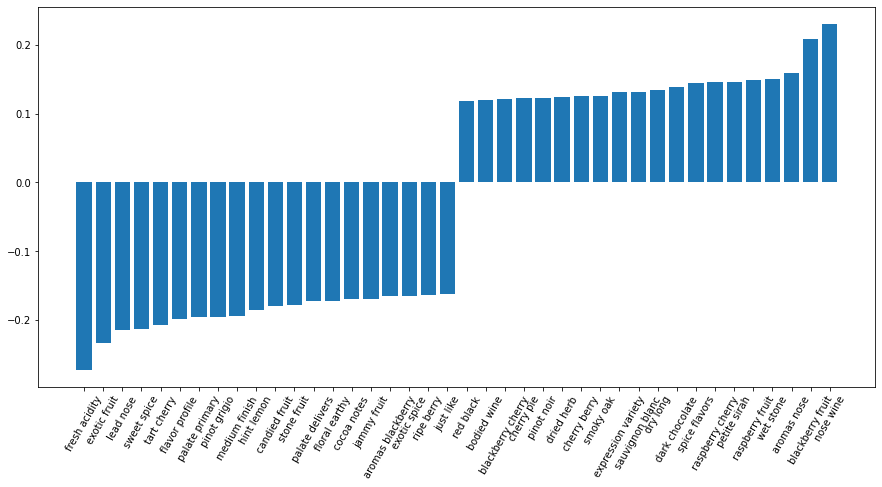

In [12]:
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 2


clf = grid.best_estimator_.fit(x_train, y_train)
coef = clf.coef_.ravel()[mask]
list = [(n, c) for n, c in zip(feature_names[mask], coef)]
list = sorted(list, key=lambda x: x[1])
list = list[:20] + list[-20:]

words, coef = zip(*list)
idx = np.arange(len(words))

plt.figure(figsize=(15,7))
plt.bar(idx, coef, width=0.8)
plt.xticks(idx, words, rotation=60)
plt.show()

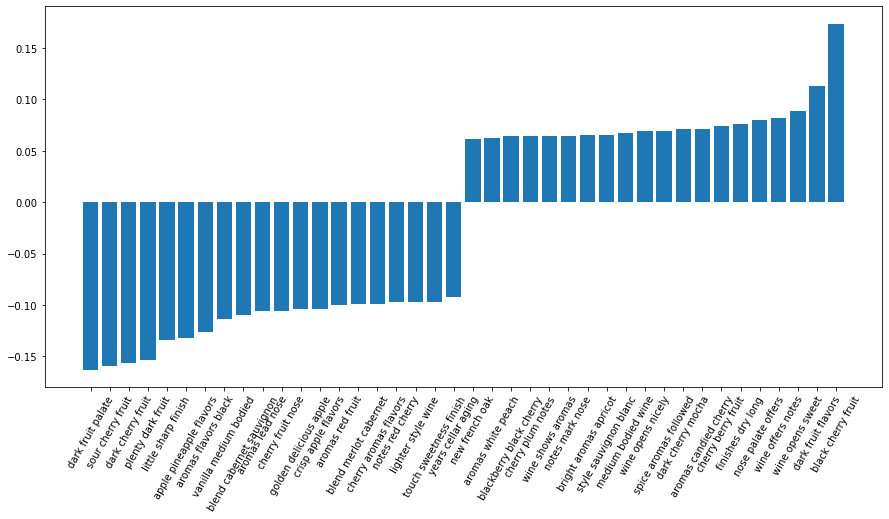

In [13]:
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3


clf = grid.best_estimator_.fit(x_train, y_train)
coef = clf.coef_.ravel()[mask]
list = [(n, c) for n, c in zip(feature_names[mask], coef)]
list = sorted(list, key=lambda x: x[1])
list = list[:20] + list[-20:]

words, coef = zip(*list)
idx = np.arange(len(words))

plt.figure(figsize=(15,7))
plt.bar(idx, coef, width=0.8)
plt.xticks(idx, words, rotation=60)
plt.show()